# Retroactive Data Analysis

## Imports

In [40]:
import os
import pandas
import statsmodels.api as sm
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append('/Users/jim/repos/poincare/axiom')

In [41]:
from axiom.vis.plotting.ggplot2 import image, gg2

In [2]:
from mpow import load_data, plotting, regression
plotting.output_notebook(hide_banner=True)

## Load data

In [24]:
data = load_data.norm_daily_data()
intraday = load_data.norm_intraday_data()
details = load_data.norm_detail_data()

In [23]:
data.head()

,Patient,DayNum,Intake,PainScore,NumObs,AgeAtAdmit,Gender,ImpairmentGroup,Depression
0,1,1,80.0,29.0,7,32,Female,Spinal_Cord_Dysfunction,0
1,1,2,60.0,24.0,9,32,Female,Spinal_Cord_Dysfunction,0
2,1,3,70.0,38.0,11,32,Female,Spinal_Cord_Dysfunction,0
3,1,4,40.0,23.0,11,32,Female,Spinal_Cord_Dysfunction,0
4,2,1,75.0,63.0,14,56,Female,Spinal_Cord_Dysfunction,1


In [27]:
details.head()

,Patient,AgeAtAdmit,Gender,Depression,ImpairmentGroup
0,1,32,Female,0,Spinal_Cord_Dysfunction
1,2,56,Female,1,Spinal_Cord_Dysfunction
2,3,82,Male,0,Stroke
3,4,92,Male,0,Debility
4,5,67,Female,1,Orthopaedic_Disorders


## Explore details

### Age

Overall Distribution

In [28]:
plotting.show(plotting.histogram(details.AgeAtAdmit, bins=15))

Conditional on gender

In [29]:
details[['Gender', 'AgeAtAdmit']].groupby('Gender').median()

,AgeAtAdmit
Gender,
Female,68
Male,67


Conditional on depression

In [30]:
details[['Depression', 'AgeAtAdmit']].groupby('Depression').median()

,AgeAtAdmit
Depression,
0,68
1,67


Conditional on impairment

In [31]:
details[['ImpairmentGroup', 'AgeAtAdmit']].groupby('ImpairmentGroup').median().sort_values('AgeAtAdmit')

,AgeAtAdmit
ImpairmentGroup,
Congenital_Deformities,25.0
Amputations,58.0
Neurologic_conditions,58.5
Pulmonary_Disorders,59.0
Burns,60.0
Brain_Dysfunction,60.5
Neuromuscular_disorders,64.0
Stroke,65.0
Debility,67.0


### Impairment

In [23]:
details.ImpairmentGroup.value_counts()

Orthopaedic_Disorders      33
Spinal_Cord_Dysfunction    26
Stroke                     13
Debility                    5
Amputations                 5
Cardiac                     4
Neuromuscular_disorders     4
Pulmonary_Disorders         3
Neurologic_conditions       3
Major_Multiple_Trauma       2
Burns                       1
Congenital_Deformities      1
Brain_Dysfunction           1
Name: ImpairmentGroup, dtype: int64

## Depression Gender Interaction

Model: $$\LARGE{s_{t,i} \sim \beta_{0} + \beta_{1}p_{t,i} + \alpha^{df} + \alpha^{nf} + \alpha^{dm} + \alpha^{nm} + \epsilon_{t,i}}$$

Sufficiency?

In [34]:
dgi_cats = {2:'FemNon',3:'MaleNon',4:'FemDep',6:'MaleDep'}
dgi_counts = (((details.Depression + 1) * ((details.Gender=='Male').astype(int) + 2))
            .to_frame('DepGenInter').applymap(dgi_cats.get))
dgi_counts.DepGenInter.value_counts()

MaleNon    55
FemNon     46
FemDep     44
MaleDep     9
Name: DepGenInter, dtype: int64

In [35]:
dgi = data.copy()
dgi['FemDep'] = ((dgi.Depression==1)&(dgi.Gender=='Female')).astype(int)
dgi['MaleDep'] = ((dgi.Depression==1)&(dgi.Gender=='Male')).astype(int)
dgi['FemNon'] = ((dgi.Depression==0)&(dgi.Gender=='Female')).astype(int)
dgi['MaleNon'] = ((dgi.Depression==0)&(dgi.Gender=='Male')).astype(int)

In [57]:
dgi['MPS'] = dgi['PainScore'] / dgi['NumObs']

In [58]:
dgi_model = regression.ols(dgi.dropna(), ['MPS', 'FemDep', 'MaleDep', 'FemNon', 'MaleNon'], 'Intake')
dgi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Intake   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     133.4
Date:                Tue, 28 Nov 2017   Prob (F-statistic):           5.45e-98
Time:                        19:29:23   Log-Likelihood:                -7376.4
No. Observations:                1551   AIC:                         1.476e+04
Df Residuals:                    1546   BIC:                         1.479e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5244      1.099      6.849      0.000       5.369       9.680
MPS            7.8207      0.380     20.587      0.000       7.076       8.566
FemDep        12.2337      1.316      9.295      0.000       9.652      14.815
MaleDep       -1.6211      2.505     -0.647      0.518      -6.534       3.292
FemNon         0.1522      1.334      0.114      0.909      -2.464       2.768
MaleNon       -3.2404      1.158     -2.798      0.005      -5.512      -0.968
==============================================================================
Omnibus:                      795.556   Durbin-Watson:                   0.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6508.123
Skew:                           2.258   Prob(JB):                         0.00
Kurtosis:                      11.962   Cond. No.                     2.54e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.58e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [62]:
bse = dict(dgi_model.bse)
for param, coeff in dict(dgi_model.params).items():
    print('{}:\t{:.3f}\t({:.3f}, {:.3f})'.format(param[:5], coeff, coeff - 1.96*bse[param], coeff + 1.96*bse[param]))

const:	7.524	(5.371, 9.678)
MPS:	7.821	(7.076, 8.565)
FemDe:	12.234	(9.654, 14.813)
MaleD:	-1.621	(-6.530, 3.288)
FemNo:	0.152	(-2.462, 2.766)
MaleN:	-3.240	(-5.511, -0.970)


In [43]:
tmp = dgi.copy()
tmp = tmp[['MeanPainScore', 'Intake', 'Gender', 'Depression']]
tmp['Gender'] = (tmp['Gender']=='Male').astype(int) + 1
tmp['Depression'] = tmp['Depression'] + 2
tmp['DepGenInteraction'] = (tmp['Depression'] * tmp['Gender']).apply({2:'FemNon',3:'FemDep',4:'MaleNon',6:'MaleDep'}.get)

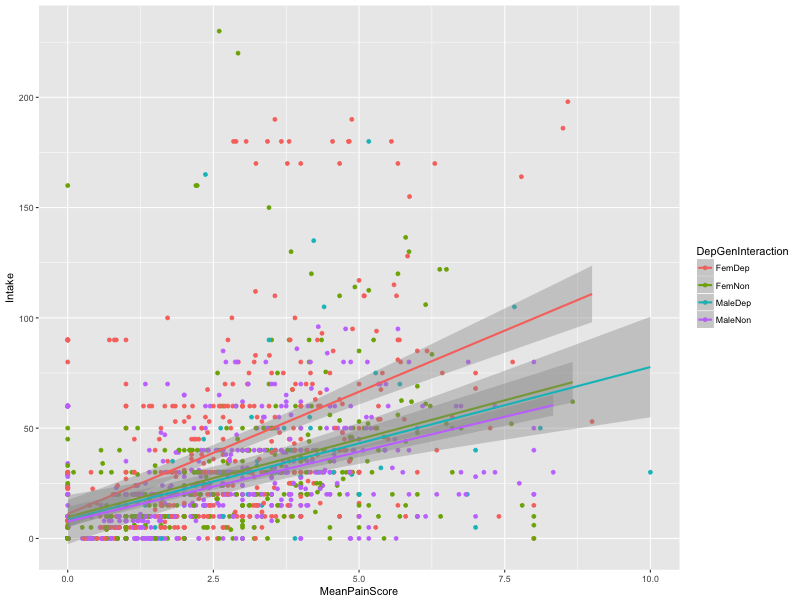

In [46]:
image(gg2.ggplot(tmp[['MeanPainScore', 'Intake', 'DepGenInteraction']]) + 
      gg2.aes_string(x='MeanPainScore', y='Intake', color='DepGenInteraction') + 
      gg2.geom_point() + gg2.stat_smooth(method='lm'))